## 🔧 Моделювання, ансамблювання та деплой

У цьому ноутбуці представлено фінальний етап роботи над задачею визначення дублікатів запитань.

На основі попереднього дослідження та порівняння моделей, тут зосереджено увагу на:
- тонкому налаштуванні найкращих моделей;
- аналізі помилок та слабких місць моделей;
- побудові ансамблевих рішень;
- формуванні єдиного пайплайна обробки даних та передбачення;
- підготовці моделі до подальшого використання (деплой).

Метою цього етапу є отримання стабільної, інтерпретованої та ефективної моделі,
яка демонструє найкращу якість за обраною метрикою та може бути використана на практиці.

### Підбір гіперпараметрів для LightGBM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import log_loss
def evaluate_model(y_train_pred, y_val_pred, y_train, y_val, model_name="model"):
    """
    Оцінює модель по Cross-Entropy Loss (Log Loss)
    """

    train_loss = log_loss(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred)

    print(f"{model_name}")
    print(f"  Train Log Loss: {train_loss:.4f}")
    print(f"  Val   Log Loss: {val_loss:.4f}")

    return {
        "model": model_name,
        "train_log_loss": train_loss,
        "val_log_loss": val_loss
    }

In [3]:
import joblib
from scipy.sparse import load_npz
import pandas as pd

df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/features_emb_test.csv.zip")
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/features_emb_train.csv.zip")

In [4]:
from scipy.sparse import hstack

tfidf_q1_train = load_npz("/content/drive/MyDrive/Colab Notebooks/tfidf_q1_train.npz")
tfidf_q2_train = load_npz("/content/drive/MyDrive/Colab Notebooks/tfidf_q2_train.npz")
tfidf_q1_test = load_npz("/content/drive/MyDrive/Colab Notebooks/tfidf_q1_test.npz")
tfidf_q2_test = load_npz("/content/drive/MyDrive/Colab Notebooks/tfidf_q2_test.npz")
X_tfidf_train = hstack([tfidf_q1_train, tfidf_q2_train])
X_tfidf_test = hstack([tfidf_q1_test, tfidf_q2_test])

In [5]:
train_cols = ["common_words",	"jaccard", "lev_ratio",	"bigram_overlap",	"trigram_overlap",	"cosine_sim",	"manhattan", "euclidean", "sbert_cosine"]
X_train_emb = df_train[train_cols].copy()
X_test_emb = df_test[train_cols].copy()
y_train = df_train["is_duplicate"].copy()
y_test = df_test["is_duplicate"].copy()

In [6]:
X_train_stack = hstack([X_tfidf_train, X_train_emb.values])
X_test_stack = hstack([X_tfidf_test, X_test_emb.values])

In [ ]:
import pandas as pd
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

X_train_stack = hstack([X_tfidf_train, X_train_emb.values])
X_test_stack = hstack([X_tfidf_test, X_test_emb.values])

LightGBM_model = LGBMClassifier(
        objective='binary',
        n_estimators=500,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
LightGBM_model.fit(X_train_stack, y_train)
y_proba_test = LightGBM_model.predict_proba(X_test_stack)
y_proba_train = LightGBM_model.predict_proba(X_train_stack)
evaluate_model(y_proba_train[:, 1], y_proba_test[:, 1], y_train, y_test, model_name="LightGBM_emb")

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


LightGBM_emb
  Train Log Loss: 0.2962
  Val   Log Loss: 0.3087


{'model': 'LightGBM_emb',
 'train_log_loss': 0.29624208151317066,
 'val_log_loss': 0.308742517951506}

In [ ]:
param_dist = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 5, 10, 15],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 800, 1200],
    "min_child_samples": [20, 50, 100],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5],
    "reg_lambda": [0.0, 0.1, 0.5],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, log_loss
import numpy as np


lgbm = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_log_loss",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train_stack, y_train)

print("Best params:")
print(random_search.best_params_)

print("Best CV log loss:")
print(-random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=800, num_leaves=31, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  60.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=800, num_leaves=31, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 1.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=800, num_leaves=31, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time=  54.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=1200, num_leaves=127, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time= 3.9min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=1200, num_leaves=127, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time= 4.4min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=1200, num_leaves=127, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time= 4.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=15, min_child_samples=20, n_estimators=1200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time= 1.3min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=15, min_child_samples=20, n_estimators=1200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time= 1.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=15, min_child_samples=20, n_estimators=1200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7; total time= 1.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_samples=50, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  21.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_samples=50, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  21.1s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_samples=50, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  20.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=-1, min_child_samples=100, n_estimators=800, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  49.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=-1, min_child_samples=100, n_estimators=800, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  48.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=-1, min_child_samples=100, n_estimators=800, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  49.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=800, num_leaves=127, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  45.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=800, num_leaves=127, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  45.5s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=800, num_leaves=127, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9; total time=  47.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=-1, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  25.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=-1, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  25.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=-1, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  25.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=63, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  55.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=63, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  56.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=63, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  55.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_samples=50, n_estimators=500, num_leaves=127, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  27.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_samples=50, n_estimators=500, num_leaves=127, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  26.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_samples=50, n_estimators=500, num_leaves=127, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  26.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, min_child_samples=50, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  30.9s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, min_child_samples=50, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  31.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, min_child_samples=50, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0; total time=  31.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=15, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=  17.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=15, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=  17.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=15, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.1, reg_lambda=0.0, subsample=0.9; total time=  17.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, min_child_samples=100, n_estimators=800, num_leaves=63, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 1.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, min_child_samples=100, n_estimators=800, num_leaves=63, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 1.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, min_child_samples=100, n_estimators=800, num_leaves=63, reg_alpha=0.0, reg_lambda=0.5, subsample=0.8; total time= 1.1min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  44.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  44.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.5, subsample=0.7; total time=  44.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 1.8min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 1.8min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, reg_lambda=0.0, subsample=0.8; total time= 1.8min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  29.3s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  29.3s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  29.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=800, num_leaves=127, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 2.7min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=800, num_leaves=127, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 2.7min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, min_child_samples=50, n_estimators=800, num_leaves=127, reg_alpha=0.5, reg_lambda=0.0, subsample=1.0; total time= 2.7min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 1.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 1.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 1.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=50, n_estimators=500, num_leaves=63, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  57.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=50, n_estimators=500, num_leaves=63, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  59.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=50, n_estimators=500, num_leaves=63, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  57.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  53.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  53.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=  54.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=50, n_estimators=500, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  21.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=50, n_estimators=500, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  21.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=50, n_estimators=500, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=1.0; total time=  21.3s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=127, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  53.1s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=127, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  52.9s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=127, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time=  52.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=15, min_child_samples=50, n_estimators=800, num_leaves=31, reg_alpha=0.0, reg_lambda=0.1, subsample=0.7; total time=  47.5s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=15, min_child_samples=50, n_estimators=800, num_leaves=31, reg_alpha=0.0, reg_lambda=0.1, subsample=0.7; total time=  50.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=15, min_child_samples=50, n_estimators=800, num_leaves=31, reg_alpha=0.0, reg_lambda=0.1, subsample=0.7; total time=  46.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, min_child_samples=100, n_estimators=500, num_leaves=63, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time=  56.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, min_child_samples=100, n_estimators=500, num_leaves=63, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 1.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, min_child_samples=100, n_estimators=500, num_leaves=63, reg_alpha=0.5, reg_lambda=0.0, subsample=0.9; total time= 1.1min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=63, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=  51.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=63, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time= 1.0min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=63, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time= 1.1min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=63, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 1.5min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=63, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 1.4min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=63, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time= 1.5min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=1200, num_leaves=127, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  40.9s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=1200, num_leaves=127, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  41.2s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=1200, num_leaves=127, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=  40.1s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=  42.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=  42.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=100, n_estimators=300, num_leaves=63, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=  42.8s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, min_child_samples=50, n_estimators=1200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 1.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, min_child_samples=50, n_estimators=1200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 1.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=15, min_child_samples=50, n_estimators=1200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time=293.2min


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=  59.7s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=  51.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=63, reg_alpha=0.0, reg_lambda=0.1, subsample=1.0; total time=  51.0s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=800, num_leaves=127, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  41.6s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=800, num_leaves=127, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  41.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=800, num_leaves=127, reg_alpha=0.0, reg_lambda=0.1, subsample=0.9; total time=  41.4s


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best params:
{'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 800, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best CV log loss:
0.2965630879342515


In [ ]:
best_lgbm = random_search.best_estimator_

y_train_pred = best_lgbm.predict_proba(X_train_stack)[:, 1]
y_val_pred   = best_lgbm.predict_proba(X_test_stack)[:, 1]

evaluate_model(
    y_train_pred,
    y_val_pred,
    y_train,
    y_test,
    model_name="LightGBM tuned SBERT metrics + TF-IDF"
)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


LightGBM tuned (SBERT)
  Train Log Loss: 0.2584
  Val   Log Loss: 0.2916


{'model': 'LightGBM tuned (SBERT)',
 'train_log_loss': 0.25836377617338246,
 'val_log_loss': 0.2915845498528135}

In [7]:
from lightgbm import LGBMClassifier
lgbm_best = LGBMClassifier(
    subsample=1.0,
    colsample_bytree=0.7,
    learning_rate=0.1,
    n_estimators=800,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    reg_alpha=0.5,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)


lgbm_best.fit(X_train_stack, y_train)
y_train_pred = lgbm_best.predict_proba(X_train_stack)[:, 1]
y_test_pred  = lgbm_best.predict_proba(X_test_stack)[:, 1]
evaluate_model(y_train_pred,y_test_pred, y_train, y_test, model_name="LightGBM_emb")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


LightGBM_emb
  Train Log Loss: 0.2584
  Val   Log Loss: 0.2916


{'model': 'LightGBM_emb',
 'train_log_loss': 0.2583637761733815,
 'val_log_loss': 0.29158454985281185}

In [29]:
import joblib
from lightgbm import LGBMClassifier

joblib.dump(lgbm_best, "lgbm_best_model.pkl")

['lgbm_best_model.pkl']

In [ ]:
y_pred = (y_val_pred >= 0.5).astype(int)

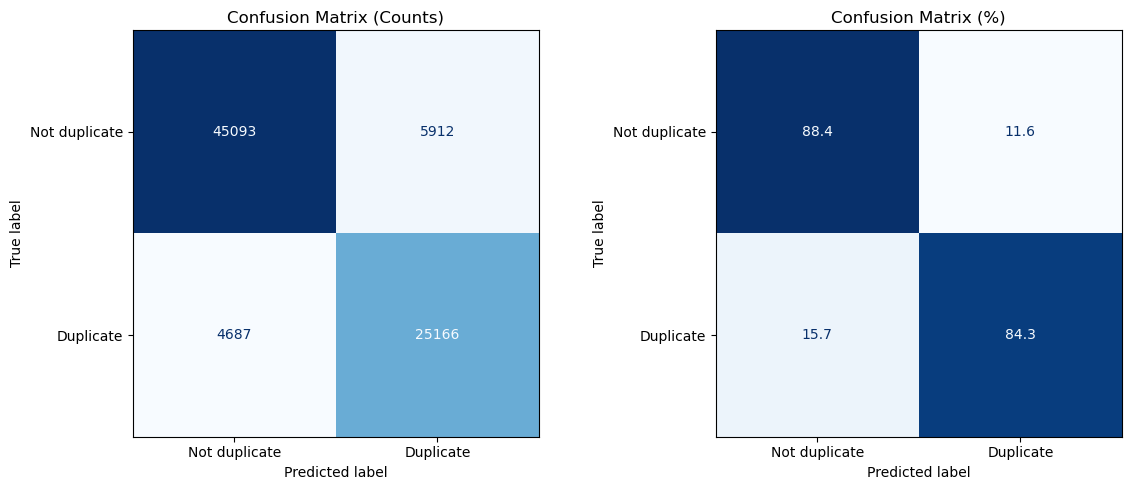

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


cm_counts = confusion_matrix(y_test, y_pred)
cm_percent = confusion_matrix(y_test, y_pred, normalize="true") * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_counts,
    display_labels=["Not duplicate", "Duplicate"]
)
disp1.plot(
    cmap="Blues",
    values_format="d",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title("Confusion Matrix (Counts)")

disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_percent,
    display_labels=["Not duplicate", "Duplicate"]
)
disp2.plot(
    cmap="Blues",
    values_format=".1f",
    ax=axes[1],
    colorbar=False
)
axes[1].set_title("Confusion Matrix (%)")

plt.tight_layout()
plt.show()

Для кращої інтерпретації результатів було побудовано дві матриці помилок:
одна в абсолютних значеннях, інша — у відсотках відносно істинних класів.
Це дозволяє оцінити як загальну кількість помилок, так і якість розпізнавання кожного класу окремо.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=["Not duplicate", "Duplicate"]
))

               precision    recall  f1-score   support

Not duplicate       0.91      0.88      0.89     51005
    Duplicate       0.81      0.84      0.83     29853

     accuracy                           0.87     80858
    macro avg       0.86      0.86      0.86     80858
 weighted avg       0.87      0.87      0.87     80858



ROC-AUC: 0.9432


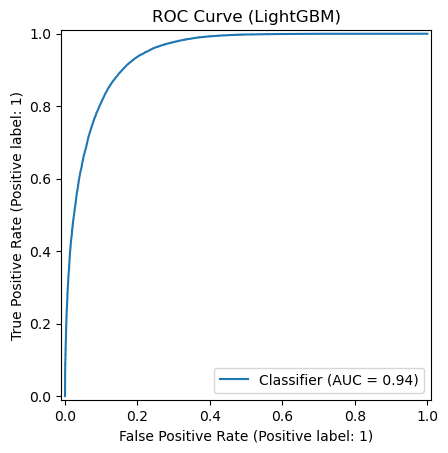

In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

roc_auc = roc_auc_score(y_test, y_val_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_val_pred)
plt.title("ROC Curve (LightGBM)")
plt.show()

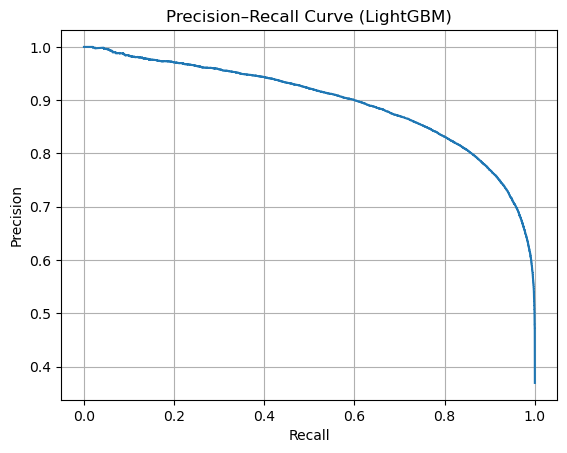

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_val_pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (LightGBM)")
plt.grid()
plt.show()

Precision–Recall крива демонструє стабільний компроміс між повнотою та точністю. Модель зберігає відносно високий рівень precision навіть при збільшенні recall, що свідчить про здатність розрізняти дублікатні та недублікатні пари.

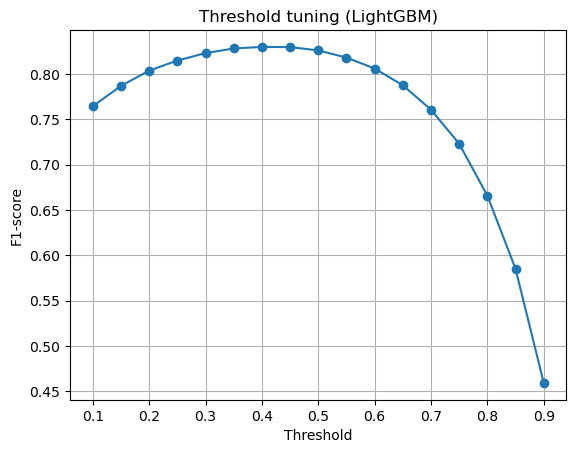

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 17)
f1_scores = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.plot(thresholds, f1_scores, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold tuning (LightGBM)")
plt.grid()
plt.show()

Було встановлено, що оптимальний поріг класифікації для даної задачі становить 0.4, що дозволяє покращити якість передбачень порівняно зі стандартним порогом 0.5. Це підкреслює важливість калібрування рішення моделі з урахуванням специфіки даних.

### Останнє навчання нейронки

In [16]:
import numpy as np
emb_q1_train = np.load("/content/drive/MyDrive/Colab Notebooks/emb_q1_fp16_train.npy")
emb_q2_train = np.load("/content/drive/MyDrive/Colab Notebooks/emb_q2_fp16_train.npy")
emb_q1_test = np.load("/content/drive/MyDrive/Colab Notebooks/emb_q1_fp16_test.npy")
emb_q2_test = np.load("/content/drive/MyDrive/Colab Notebooks/emb_q2_fp16_test.npy")

In [17]:
X_sbert_train = np.hstack([emb_q1_train, emb_q2_train, np.abs(emb_q1_train - emb_q2_train)])
X_sbert_test  = np.hstack([emb_q1_test, emb_q2_test, np.abs(emb_q1_test - emb_q2_test)])

In [18]:
import joblib

scaler = joblib.load("/content/drive/MyDrive/Colab Notebooks/sbert_scaler_0,28.pkl")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [19]:
X_sbert_train_scaled = scaler.fit_transform(X_sbert_train)
X_sbert_test_scaled = scaler.transform(X_sbert_test)

In [20]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [21]:
from torch.utils.data import DataLoader, TensorDataset
X_train_tensor = torch.tensor(X_sbert_train_scaled, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_sbert_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
from torch import nn
class SBERTMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

mlp_model = SBERTMLP(X_sbert_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4, weight_decay=1e-4)

n_epochs = 10
for epoch in range(n_epochs):
    mlp_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = mlp_model(xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

mlp_model.eval()
with torch.no_grad():
    y_train_pred_mlp = torch.sigmoid(
        mlp_model(X_train_tensor)
    ).cpu().numpy().squeeze()

    y_test_pred_mlp = torch.sigmoid(
        mlp_model(X_test_tensor)
    ).cpu().numpy().squeeze()

evaluate_model(y_train_pred_mlp, y_test_pred_mlp, y_train, y_test, "MLP SBERT")

Epoch 1/10, Loss: 0.3797
Epoch 2/10, Loss: 0.2172
Epoch 3/10, Loss: 0.2537
Epoch 4/10, Loss: 0.3117
Epoch 5/10, Loss: 0.2363
Epoch 6/10, Loss: 0.2033
Epoch 7/10, Loss: 0.2433
Epoch 8/10, Loss: 0.3611
Epoch 9/10, Loss: 0.2137
Epoch 10/10, Loss: 0.2165
MLP SBERT
  Train Log Loss: 0.1798
  Val   Log Loss: 0.2876


{'model': 'MLP SBERT',
 'train_log_loss': 0.17978916205446804,
 'val_log_loss': 0.28758199713298543}

In [ ]:
torch.save(mlp_model.state_dict(), "sbert_mlp_0,28.pt")

In [ ]:
import joblib
joblib.dump(scaler, "sbert_scaler.pkl")

['sbert_scaler.pkl']

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Оцінка результатів нейронки

In [22]:
from torch import nn

class SBERTMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

In [23]:
mlp_model = SBERTMLP(input_dim=X_sbert_train.shape[1]).to(device)
mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/sbert_mlp_0,28.pt", map_location=device))
mlp_model.eval()

SBERTMLP(
  (model): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [24]:
with torch.no_grad():
    y_train_pred_mlp = torch.sigmoid(
        mlp_model(X_train_tensor)
    ).cpu().numpy().squeeze()

    y_test_pred_mlp = torch.sigmoid(
        mlp_model(X_test_tensor)
    ).cpu().numpy().squeeze()

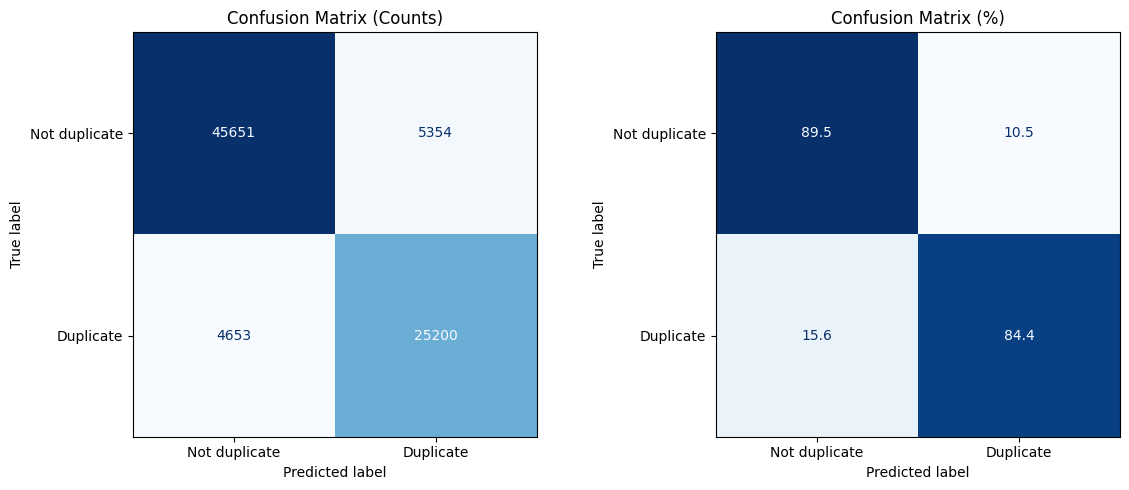

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

threshold = 0.5
y_test_pred_mlp_cls = (y_test_pred_mlp >= threshold).astype(int)

cm_counts = confusion_matrix(y_test, y_test_pred_mlp_cls)
cm_percent = confusion_matrix(y_test, y_test_pred_mlp_cls, normalize="true") * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_counts,
    display_labels=["Not duplicate", "Duplicate"]
)
disp1.plot(
    cmap="Blues",
    values_format="d",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title("Confusion Matrix (Counts)")

disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_percent,
    display_labels=["Not duplicate", "Duplicate"]
)
disp2.plot(
    cmap="Blues",
    values_format=".1f",
    ax=axes[1],
    colorbar=False
)
axes[1].set_title("Confusion Matrix (%)")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df_errors = pd.DataFrame({
    "y_true": y_test,
    "p_lgbm": y_test_pred,
    "p_mlp": y_test_pred_mlp
})

df_errors["pred_lgbm"] = (df_errors["p_lgbm"] >= 0.5).astype(int)
df_errors["pred_mlp"]  = (df_errors["p_mlp"] >= 0.5).astype(int)

df_errors["lgbm_correct"] = df_errors["pred_lgbm"] == df_errors["y_true"]
df_errors["mlp_correct"]  = df_errors["pred_mlp"]  == df_errors["y_true"]

In [ ]:
df_errors["case"] = "both_correct"
df_errors.loc[(~df_errors.lgbm_correct) & (~df_errors.mlp_correct), "case"] = "both_wrong"
df_errors.loc[(df_errors.lgbm_correct) & (~df_errors.mlp_correct), "case"] = "lgbm_only"
df_errors.loc[(~df_errors.lgbm_correct) & (df_errors.mlp_correct), "case"] = "mlp_only"

df_errors["case"].value_counts(normalize=True)

,proportion
case,
both_correct,0.823864
both_wrong,0.078706
mlp_only,0.052376
lgbm_only,0.045054


Цікаво, що є суммарно 12 відсодків випадків коли одна з моделей права, а інша помиляється. Якщо використати сильні сторони моделей, можна покращити результати

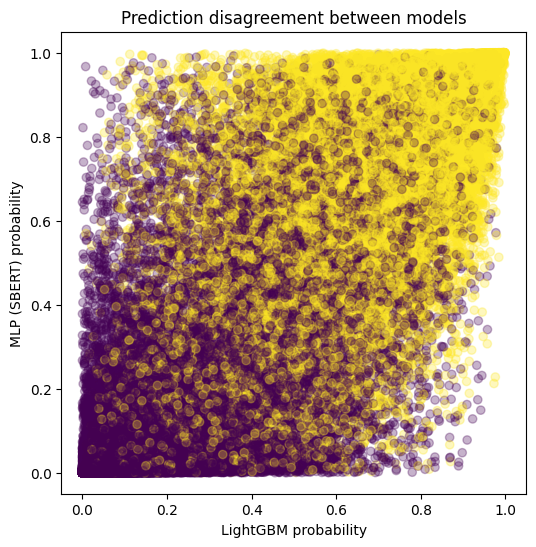

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df_errors.p_lgbm, df_errors.p_mlp, c=df_errors.y_true, alpha=0.3)
plt.xlabel("LightGBM probability")
plt.ylabel("MLP (SBERT) probability")
plt.title("Prediction disagreement between models")
plt.show()

Scatter-графік ймовірностей двох моделей показує, що хоча крайні області (низькі та високі значення) добре відокремлені, значна частина спостережень розташована в проміжній зоні.
Це свідчить про те, що моделі роблять різні помилки та по-різному оцінюють невпевнені приклади, що створює передумови для ефективного ансамблювання.

### Ансамбль моделей

In [ ]:
lgbm_model = joblib.load("lgbm_best_model.pkl")

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

lgbm_train_proba = y_train_pred#lgbm_model.predict_proba(X_train_stack)[:,1]
lgbm_val_proba   = y_test_pred #lgbm_model.predict_proba(X_test_stack)[:,1]


mlp_train_proba = y_train_pred_mlp
mlp_val_proba   = y_test_pred_mlp


X_meta_train = np.vstack([lgbm_train_proba, mlp_train_proba]).T
X_meta_val   = np.vstack([lgbm_val_proba, mlp_val_proba]).T

y_meta_train = y_train
y_meta_val   = y_test


meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_meta_train)

y_meta_train_pred = meta_model.predict_proba(X_meta_train)[:,1]
y_meta_val_pred   = meta_model.predict_proba(X_meta_val)[:,1]

evaluate_model(y_meta_train_pred, y_meta_val_pred, y_train, y_test, model_name="Ansamble")

Ansamble
  Train Log Loss: 0.1783
  Val   Log Loss: 0.3111


{'model': 'Ansamble',
 'train_log_loss': 0.17834346660927541,
 'val_log_loss': 0.3110908250714208}

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

X_meta_train = np.vstack([lgbm_train_proba, y_train_pred_mlp]).T
X_meta_val   = np.vstack([lgbm_val_proba, y_test_pred_mlp]).T

y_meta_train = y_train
y_meta_val   = y_test

X_meta_train_tensor = torch.tensor(X_meta_train, dtype=torch.float32).to(device)
X_meta_val_tensor   = torch.tensor(X_meta_val, dtype=torch.float32).to(device)
y_meta_train_tensor = torch.tensor(y_meta_train, dtype=torch.float32).to(device)
y_meta_val_tensor   = torch.tensor(y_meta_val, dtype=torch.float32).to(device)

meta_train_dataset = TensorDataset(X_meta_train_tensor, y_meta_train_tensor)
meta_train_loader = DataLoader(meta_train_dataset, batch_size=256, shuffle=True)

class MetaMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.model(x)

meta_model = MetaMLP(X_meta_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(meta_model.parameters(), lr=5e-5)

n_epochs = 30
for epoch in range(n_epochs):
    meta_model.train()
    for xb, yb in meta_train_loader:
        optimizer.zero_grad()
        pred = meta_model(xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(meta_model.parameters(), max_norm=1.0)
        optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

meta_model.eval()
with torch.no_grad():
    y_meta_train_pred = torch.sigmoid(meta_model(X_meta_train_tensor)).cpu().numpy().squeeze()
    y_meta_val_pred   = torch.sigmoid(meta_model(X_meta_val_tensor)).cpu().numpy().squeeze()

evaluate_model(y_meta_train_pred, y_meta_val_pred, y_meta_train, y_meta_val, "Meta-MLP Stacking")

Epoch 1/30, Loss: 0.6573
Epoch 2/30, Loss: 0.6196
Epoch 3/30, Loss: 0.5696
Epoch 4/30, Loss: 0.5361
Epoch 5/30, Loss: 0.5200
Epoch 6/30, Loss: 0.4619
Epoch 7/30, Loss: 0.4180
Epoch 8/30, Loss: 0.3881
Epoch 9/30, Loss: 0.3298
Epoch 10/30, Loss: 0.3466
Epoch 11/30, Loss: 0.3527
Epoch 12/30, Loss: 0.2944
Epoch 13/30, Loss: 0.2500
Epoch 14/30, Loss: 0.1990
Epoch 15/30, Loss: 0.2654
Epoch 16/30, Loss: 0.2266
Epoch 17/30, Loss: 0.2521
Epoch 18/30, Loss: 0.2896
Epoch 19/30, Loss: 0.1936
Epoch 20/30, Loss: 0.2094
Epoch 21/30, Loss: 0.1419
Epoch 22/30, Loss: 0.2935
Epoch 23/30, Loss: 0.1713
Epoch 24/30, Loss: 0.2372
Epoch 25/30, Loss: 0.1522
Epoch 26/30, Loss: 0.1540
Epoch 27/30, Loss: 0.2529
Epoch 28/30, Loss: 0.1756
Epoch 29/30, Loss: 0.2131
Epoch 30/30, Loss: 0.1987
Meta-MLP Stacking
  Train Log Loss: 0.1817
  Val   Log Loss: 0.3027


{'model': 'Meta-MLP Stacking',
 'train_log_loss': 0.1816704165463959,
 'val_log_loss': 0.30266068866320106}

In [ ]:
lgbm_val_proba, y_test_pred_mlp
#y_pred_lgbm = lgbm_model.predict_proba(X_val_stack)[:,1]
#y_pred_mlp  = torch.sigmoid(mlp_model(X_val_tensor)).cpu().numpy().squeeze()

w_lgbm = 0.4
w_mlp  = 0.6

y_pred_ensemble = w_lgbm * lgbm_val_proba + w_mlp * y_test_pred_mlp

evaluate_model(y_pred_ensemble, y_pred_ensemble, y_test, y_test, "Weighted Ensemble")

Weighted Ensemble
  Train Log Loss: 0.2683
  Val   Log Loss: 0.2683


{'model': 'Weighted Ensemble',
 'train_log_loss': 0.26829157966712913,
 'val_log_loss': 0.26829157966712913}

Цікаво, що найпростіший метод ансамблювання показав найкращі результати 😏

In [28]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import log_loss


def logloss_w(w, preds1, preds2, y_true):
    combined = w * preds1 + (1-w) * preds2
    combined = np.clip(combined, 1e-7, 1-1e-7)
    return log_loss(y_true, combined)

w0 = 0.5

bounds = [(0, 1)]

res = minimize(logloss_w, w0, args=(lgbm_val_proba, y_test_pred_mlp, y_test),
               bounds=bounds, method='L-BFGS-B')

w_lgbm_opt = res.x[0]
w_mlp_opt = 1 - w_lgbm_opt

print(f"Оптимальні ваги: LGBM = {w_lgbm_opt:.3f}, MLP = {w_mlp_opt:.3f}")

y_pred_ensemble = w_lgbm_opt * lgbm_val_proba + w_mlp_opt * y_test_pred_mlp

evaluate_model(y_pred_ensemble, y_pred_ensemble, y_test, y_test, "Weighted Ensemble")

Оптимальні ваги: LGBM = 0.398, MLP = 0.602
Weighted Ensemble
  Train Log Loss: 0.2683
  Val   Log Loss: 0.2683


{'model': 'Weighted Ensemble',
 'train_log_loss': 0.26829119557442976,
 'val_log_loss': 0.26829119557442976}

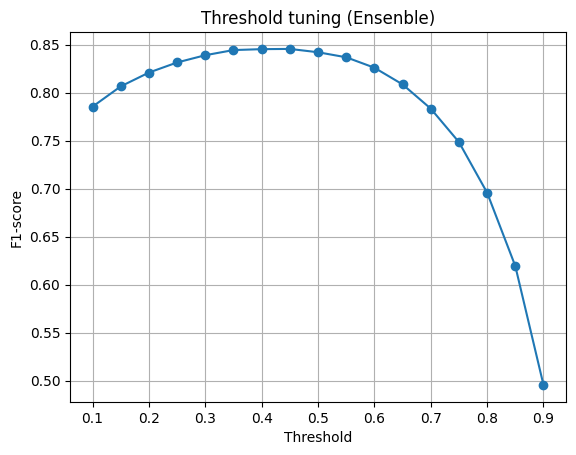

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 17)
f1_scores = []

for t in thresholds:
    preds = (y_pred_ensemble >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.plot(thresholds, f1_scores, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold tuning (Ensenble)")
plt.grid()
plt.show()

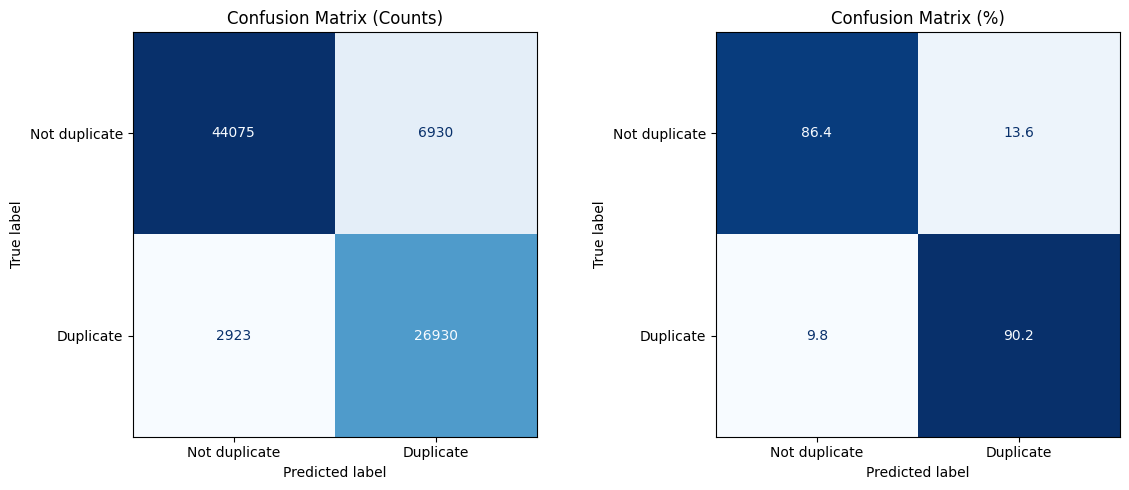

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

threshold = 0.4
y_test_pred_mlp_cls = (y_pred_ensemble >= threshold).astype(int)
cm_counts = confusion_matrix(y_test, y_test_pred_mlp_cls)
cm_percent = confusion_matrix(y_test, y_test_pred_mlp_cls, normalize="true") * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_counts,
    display_labels=["Not duplicate", "Duplicate"]
)
disp1.plot(
    cmap="Blues",
    values_format="d",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title("Confusion Matrix (Counts)")

disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_percent,
    display_labels=["Not duplicate", "Duplicate"]
)
disp2.plot(
    cmap="Blues",
    values_format=".1f",
    ax=axes[1],
    colorbar=False
)
axes[1].set_title("Confusion Matrix (%)")

plt.tight_layout()
plt.show()

🧩 Висновки після ансамблювання моделей

Ансамблювання моделей на основі зваженого поєднання LightGBM та нейронної мережі на SBERT-ембеддингах дозволило покращити узагальнюючу здатність рішення порівняно з окремими моделями.

Зокрема, ансамбль продемонстрував зниження кількості хибнопозитивних передбачень (False Positives), що є важливим з практичної точки зору: модель рідше помилково вважає різні запитання дублікатами.

Такий ефект пояснюється тим, що моделі роблять різні типи помилок:

LightGBM краще працює з інтерпретованими числовими ознаками,

нейронна мережа ефективніше захоплює семантичну схожість між питаннями.

Їх поєднання дозволяє згладити слабкі сторони кожної окремої моделі та отримати більш збалансовані передбачення.

Отримані результати підтверджують доцільність використання ансамблевих підходів для задачі визначення дублікатів запитань.